Policy Iteration Algorithm的过程：
1. 设计initial policy，可以为任意值（比如所有state都选择action 1）
2. policy evaluation： 将policy带入：贝尔曼方程 + Iterative solution，得到该策略下，每个状态的value函数 （当|Vk+1 - Vk| < threshold 时停止）
3. policy improvement: 将新的value带入贝尔曼最优方程，选择每个state中Q值（action value）最大的action，组成新的策略
重复2和3直到：策略不再发生改变/改变很小

为什么Policy Iteration Algorithm能够有用？ 简单来讲：
第一次循环，target的action选择stay，value值达到最大
第二次循环，target周围的states,它们的policies变为朝向target，values达到最大值
....
直到最后一次循环，所有values都达到最大值
这种类似于从target state开始，向周围辐射的感觉

不同于Value Iteration中的grid world。从现在开始，我的grid world是具有随机转移概率的 MDP：
每次执行一个动作，有 80% 概率执行想要的动作，10% 概率左偏，10% 概率往右偏。action4: stay则保持不变
每次执行一个动作，reward为-1，

In [46]:
import numpy as np
import matplotlib.pyplot as plt

class GridWorld:
    def __init__(self, rows=7, cols=7, goal=(5,5), reward= -1, forbidden=[(1,4),(2,3),(2,2),(3,3),(4,5)]):
        self.rows = rows
        self.cols = cols
        self.goal = goal
        self.reward = reward
        self.forbidden = set(forbidden)
        self.actions = {
            0: (-1, 0),  # up
            1: (0, 1),   # right
            2: (1, 0),   # down
            3: (0, -1),   # left
            4: (0, 0)    # stay
        }

        self.left_map = {0:3, 1:0, 2:1, 3:2, 4:4}   # 左转90°
        self.right_map = {0:1, 1:2, 2:3, 3:0, 4:4}  # 右转90°

    def step(self, state, action):
        """输入 state=(r,c), action，返回 (next_state, reward)"""
        r, c = state

        # 随机转移
        if action == 4:
            dr, dc = self.actions[action]
        else:
            prob = np.random.rand()
            if prob < 0.1:   # 左偏
                action = self.left_map[action]
            elif prob < 0.2: # 右偏
                action = self.right_map[action]
            # 其余 80% 保持不变
            dr, dc = self.actions[action]

        new_r, new_c = r + dr, c + dc

        # 撞墙
        if not (0 <= new_r < self.rows and 0 <= new_c < self.cols):
            return state, -5 + self.reward

        # 禁区
        if (new_r, new_c) in self.forbidden:
            return (new_r, new_c), -10 + self.reward

        # 到达目标
        if (new_r, new_c) == self.goal:
            return (new_r, new_c), 10 + self.reward

        # 普通移动
        return (new_r, new_c), 0 + self.reward
    
    def get_states(self):
        """返回所有可用状态"""
        states = []
        for r in range(self.rows):
            for c in range(self.cols):
                states.append((r, c))
        return states
    
    
    def render(self, policy=None, values=None, cell_size=1.2):
        """可视化：白色=正常, 黄=禁区, 蓝=goal，cell_size=每格大小"""
        fig, ax = plt.subplots(figsize=(self.cols * cell_size, self.rows * cell_size))
        
        grid = np.ones((self.rows, self.cols, 3))  # 默认白色
        for (r, c) in self.forbidden:
            grid[r, c] = [1, 1, 0]  # 黄色
        gr, gc = self.goal
        grid[gr, gc] = [0, 0, 1]  # 蓝色

        # 关键：加上 origin="upper"，确保坐标和数组一致
        ax.imshow(grid, origin="upper")

        # 如果有值函数
        if values is not None:
            for (r, c), v in values.items():
                ax.text(c, r + 0.25, f"{v:.1f}", 
                        ha='center', va='top', color='black', fontsize=12)

        # 如果有策略
        if policy is not None:
            arrows = {0: "↑", 1: "→", 2: "↓", 3: "←", 4: "O"}
            for (r, c), a in policy.items():
                ax.text(c, r - 0.2, arrows[a], ha='center', va='center',color='red', fontsize=16, fontweight='bold')

        # 设置网格
        ax.set_xticks(np.arange(-0.5, self.cols, 1))
        ax.set_yticks(np.arange(-0.5, self.rows, 1))
        ax.grid(which="both", color="black", linewidth=1)

        # 去掉刻度
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        plt.show()

In [47]:
def plot_deltas(deltas, iterations):
    """绘制策略迭代的delta变化图"""

    plt.figure(figsize=(10, 6))
    
    # 绘制每次策略评估的delta收敛过程
    for i, eval_deltas in enumerate(deltas):
        plt.plot(eval_deltas, label=f'Policy Iteration {i+1}', marker='o', markersize=4)
    
    plt.xlabel('Evaluation Steps')
    plt.ylabel('Max Delta')
    plt.title(f'Policy Iteration Convergence (Total: {iterations} iterations)')
    plt.yscale('log')  # 使用对数坐标更好地观察收敛
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [48]:
def next_state_statevalue(env, state, action, values, gamma=0.9):
    r, c = state # 当前state的坐标
    '''计算偏左动作到达state的值函数'''
    reward = -1 # 每步的基础惩罚
    action_left = env.left_map[action] # 0.1概率向左边的动作
    r_left, c_left= env.actions[action_left] # 偏左动作的坐标变化
    # 偏左动作导致的下一个state
    next_state_left = (r + r_left, c + c_left)
    if not (0 <= next_state_left[0] < env.rows and 0 <= next_state_left[1] < env.cols):  # 检测是否撞墙
        next_state_left = state # 撞墙，state保持不变
        reward = reward - 5
    elif (next_state_left in env.forbidden): # 进入禁区
        reward = reward - 10
    elif (next_state_left == env.goal): # 到达目标
        reward = reward + 10
    # 偏左动作的值函数
    action_left = reward + gamma * values[next_state_left]

    '''计算偏右动作到达state的值函数'''
    reward = -1 # 每步的基础惩罚
    action_right = env.right_map[action] # 0.1概率向右边的动作
    r_right, c_right= env.actions[action_right] # 偏右动作的坐标变化
    # 偏右动作导致的下一个state
    next_state_right = (r + r_right, c + c_right)
    if not (0 <= next_state_right[0] < env.rows and 0 <= next_state_right[1] < env.cols):# 检测是否撞墙
        next_state_right = state # 撞墙，保持不变
        reward = reward - 5
    elif (next_state_right in env.forbidden): # 进入禁区    
        reward = reward - 10
    elif (next_state_right == env.goal): # 到达目标
        reward = reward + 10
    # 偏右动作的值函数
    action_right = reward + gamma * values[next_state_right]

    '''计算正常动作到达state的值函数'''
    reward = -1 # 每步的基础惩罚
    dr, dc = env.actions[action] # 正常动作的坐标变化
    # 正常动作导致的下一个state
    next_state_normal = (r + dr, c + dc)
    if not (0 <= next_state_normal[0] < env.rows and 0 <= next_state_normal[1] < env.cols):# 检测是否撞墙
        next_state_normal = state # 撞墙，保持不变
        reward = reward - 5
    elif (next_state_normal in env.forbidden): # 进入禁区
        reward = reward - 10
    elif (next_state_normal == env.goal): # 到达目标
        reward = reward + 10

    # 正常动作的值函数
    action_normal = reward + gamma * values[next_state_normal]

    return action_left, action_right, action_normal

In [49]:
def policy_iteration(env, gamma=0.9, threshold=1e-4, max_iterations=1000):
    policy = {s: 0 for s in env.get_states()}  # 初始化策略
    values = {s: 0 for s in env.get_states()}  # 初始化值函数
    deltas = []  # 记录每次迭代的delta
    iterations = 0 # 记录迭代次数
    
    for it in range(max_iterations):
        ''' Policy Evaluation '''
        for i in range(1000):  # 内部迭代次数
            delta = 0
            for state in env.get_states():
                V_old = values[state]  # 旧的值函数
                action = policy[state]  # 当前策略下的动作

                # 计算因为概率，左，右，不偏的3种action对应的值函数
                action_left, action_right, action_normal = next_state_statevalue(env, state, action, values, gamma)
                
                # 计算新的值函数(注意stay动作没有偏移)
                if action == 4:
                    values[state] = action_normal
                else:
                    values[state] = 0.1 * action_left + 0.1 * action_right + 0.8 * action_normal

                # 计算delta，保留最大的变化
                delta = max(delta, abs(V_old - values[state]))
            if delta < threshold:
                break
        
        ''' Policy Improvement '''
        policy_stable = True  # 标记策略是否稳定
        for state in env.get_states():
            old_action = policy[state]
            best_action = None
            best_value = -float('inf')
            
            # 寻找每个state的最优action
            for a in env.actions.keys():
                action_left, action_right, action_normal = next_state_statevalue(env, state, a, values, gamma)
                if a == 4:
                    q_value = action_normal
                else:
                    q_value = 0.1 * action_left + 0.1 * action_right + 0.8 * action_normal
                
                # 找到Q值最大的动作
                if q_value > best_value:
                    best_value = q_value
                    best_action = a
            
            # 更新策略
            policy[state] = best_action
            
            # 检查策略是否改变
            if old_action != best_action:
                policy_stable = False
        
        iterations += 1
        deltas.append(abs(best_value - values[state]))  # 记录改进程度

        # 如果策略不再变化，认为收敛，退出
        if policy_stable:
            break
    
    return policy, values, deltas, iterations

所有状态： [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6)]
状态数： 49
Value Iteration converged in 184 iterations.


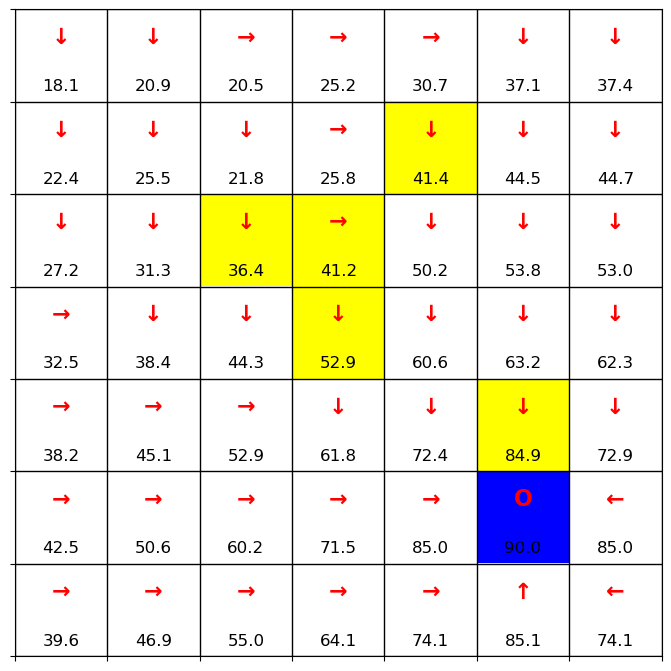

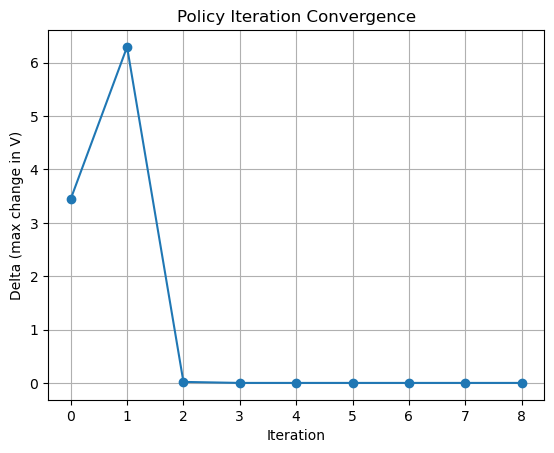

In [50]:
# 运行值迭代
env = GridWorld()

states = env.get_states()
print("所有状态：", states)
print("状态数：", len(states))
print(f"Value Iteration converged in {iterations} iterations.")

policy, values, deltas, iterations = policy_iteration(env)
env.render(policy, values)

# 绘制收敛曲线
plt.plot(deltas, marker="o")
plt.xlabel("Iteration")
plt.ylabel("Delta (max change in V)")
plt.title("Policy Iteration Convergence")
plt.grid(True)
plt.show()